In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
from src.config import RESULTS_DIR, ALL_REPRESENTATIONS
from src.condition import Condition
from src.visualize import get_pval_cmap, format_pval
from helpers import cm2inch, title

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [3]:
results = pd.read_csv(os.path.join(RESULTS_DIR, 'dist-dip-test-results.csv'), index_col=0)
results['length'].map(lambda x: f'{float(x):.0f}' if x != 'all' else 'all')
LENGTHS = results['length'].unique()

### Plot functions

In [4]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

def show_p_values(df, alpha=0.05, vmin=1e-4, vmax=1, ax=None, **kwargs):
    if ax is None:
        ax is plt.gca()
    # https://stackoverflow.com/questions/65169929/seaborn-annotate-missing-values-on-the-heatmap
    # First plot a heatmap with the NA values, then the heatmap
    sns.heatmap(
        np.where(df.isna(), 0, np.nan),
        ax=ax,
        cbar=False,
        annot=np.full_like(df, "NA", dtype=object),
        annot_kws={"color": "0.8"},
        fmt="",
        cmap=ListedColormap(['none'])
    )
    sns.heatmap(
        (df+1e-15),
        annot=df.applymap(format_pval).values,
        fmt="",
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap = get_pval_cmap(alpha, vmin, vmax),
        cbar_kws=dict(label='p value'),
        ax=ax,
        **kwargs
    )
    
# df = (results
#     .query('unique=="all" and length=="all" and dimensionality==50 and dataset=="markov"')
#     .pivot(index='representation', columns='metric', values='diptest_p'))
# show_p_values(df)

## Representation

### Main results

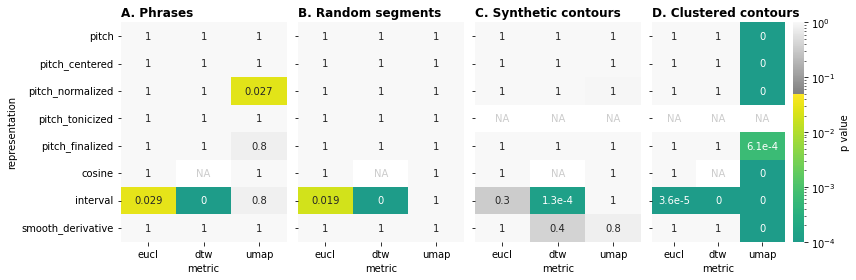

In [6]:
def results_dip_test_representation_vs_metric(query, datasets, titles=None, results=results, values='diptest_p', plot_fn=show_p_values):
    N = len(datasets)
    fig, axs = plt.subplots(1, N, sharex=True, sharey=True, figsize=(N*3, 4), tight_layout=True)
    for i, (ax, dataset) in enumerate(zip(axs, datasets)):
        df = (results.query(f'{query} and dataset=="{dataset}"')
            .pivot_table(values=values, index='representation', columns='metric')
            .reindex(index=ALL_REPRESENTATIONS, columns=['eucl', 'dtw', 'umap']))
        plot_fn(df, ax=ax, cbar=i == N-1)
        title(titles[i] if titles else dataset, ax=ax)
        if i >= 1:
            ax.set_ylabel('')

sub_dfs = results_dip_test_representation_vs_metric(
    'unique=="all" and length=="all" and dimensionality==50',
    datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
    titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours'],
    values='diptest_p'
)
plt.savefig('../figures/fig-dist-dip-test-tables/main-result-table.pdf')

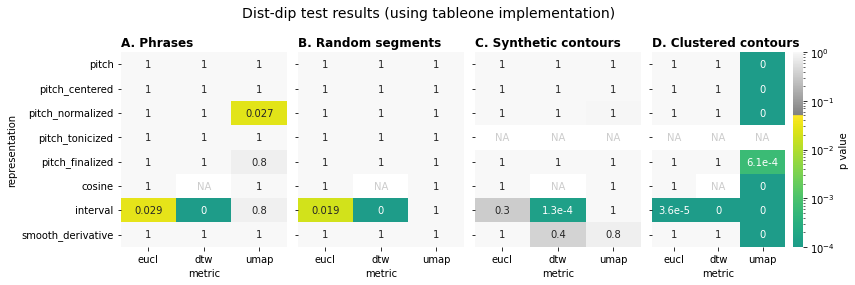

In [7]:
# Sanity check: other implementation of the dip test

results_dip_test_representation_vs_metric(
    'unique=="all" and length=="all" and dimensionality==50',
    datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
    titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours'],
    values='tableone_p'
)
plt.suptitle('Dist-dip test results (using tableone implementation)', fontsize=14);

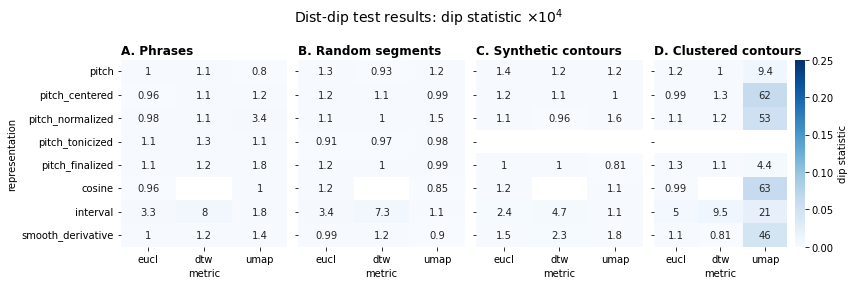

In [8]:
def show_dip_values(df, cmap='Blues', factor=1000, vmin=0, vmax=0.25, **kwargs):
    return sns.heatmap(
        df, 
        vmin=vmin, 
        vmax=vmax, 
        annot=df * factor,
        cmap=cmap, 
        cbar_kws=dict(label='dip statistic'),
        **kwargs)

results_dip_test_representation_vs_metric(
    'unique=="all" and length=="all" and dimensionality==50',
    datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
    titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours'],
    values='diptest_dip',
    plot_fn=show_dip_values
)
plt.suptitle('Dist-dip test results: dip statistic $\\times 10^4$', fontsize=14);

### Unique contours only

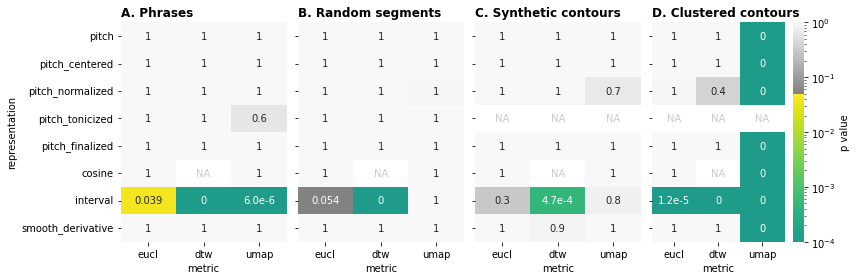

In [10]:
results_dip_test_representation_vs_metric(
    'unique=="unique" and length=="all" and dimensionality==50',
    datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
    titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours']
)
# plt.suptitle('Dist-dip test results for unique contours only', fontsize=14);
plt.savefig('../figures/fig-dist-dip-test-tables/unique-only.pdf')

### Lower-dimensional contours (10d)

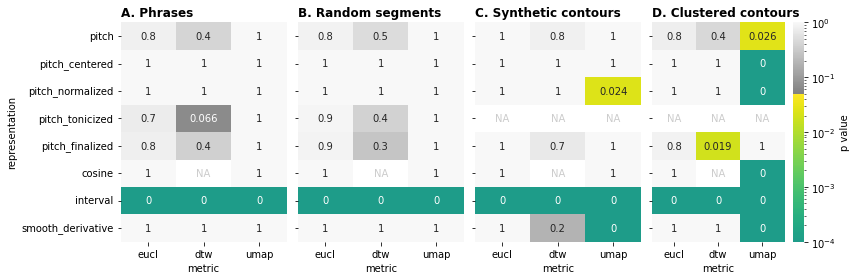

In [11]:
results_dip_test_representation_vs_metric(
    'unique=="all" and length=="all" and dimensionality==10',
    datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
    titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours']
)
# plt.suptitle('Dist-dip test results for 10 dimensional contours', fontsize=14);
plt.savefig('../figures/fig-dist-dip-test-tables/ten-dimensional.pdf')

### Per dataset

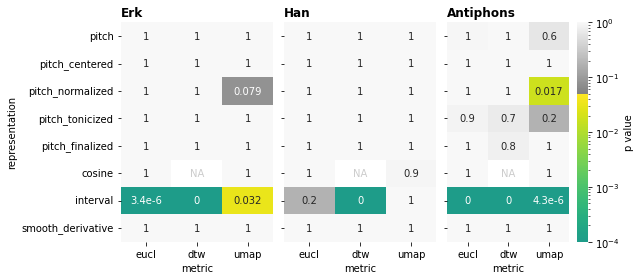

In [12]:
results_dip_test_representation_vs_metric('unique=="all" and length=="all" and dimensionality==50',
    datasets=['erk-phrase', 'han-phrase', 'liber-antiphons-phrase'],
    titles=['Erk', 'Han', 'Antiphons']
)
# plt.suptitle('Dist-dip test results for phrases from three corpora', fontsize=14);
plt.savefig('../figures/fig-dist-dip-test-tables/phrases-per-dataset.pdf')

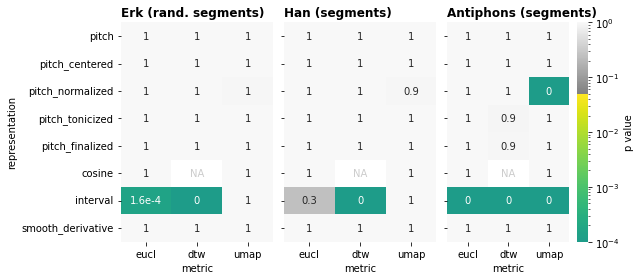

In [13]:

results_dip_test_representation_vs_metric('unique=="all" and length=="all" and dimensionality==50',
    datasets=['erk-random', 'han-random', 'liber-antiphons-random'],
    titles=['Erk (rand. segments)', 'Han (segments)', 'Antiphons (segments)']
)
# plt.suptitle('Dist-dip test results for random segments from three corpora', fontsize=14);
plt.savefig('../figures/fig-dist-dip-test-tables/random-segments-per-dataset.pdf')

### Per length

In [14]:
def results_dip_test_representation_vs_length(query, datasets, titles=None, results=results, values='diptest_p', plot_fn=show_p_values):
    N = len(datasets)
    fig, axs = plt.subplots(1, N, sharex=True, sharey=True, figsize=(N*3.5, 8), tight_layout=True)
    dfs = {}
    for i, (ax, dataset) in enumerate(zip(axs, datasets)):
        if dataset not in ['markov', 'clustered']:
            representations = ALL_REPRESENTATIONS
        else:
            representations = [r for r in ALL_REPRESENTATIONS if r != 'pitch_tonicized']
        df = (results.query(f'{query} and dataset=="{dataset}"')
            .pivot_table(values=values, index='length', columns='representation')
            .reindex(columns=representations, index=LENGTHS)
        )
        dfs[dataset] = df
        plot_fn(df, ax=ax, cbar=i == N-1)
        title(titles[i] if titles else dataset, ax=ax)
        if i >= 1:
            ax.set_ylabel('')
    return dfs

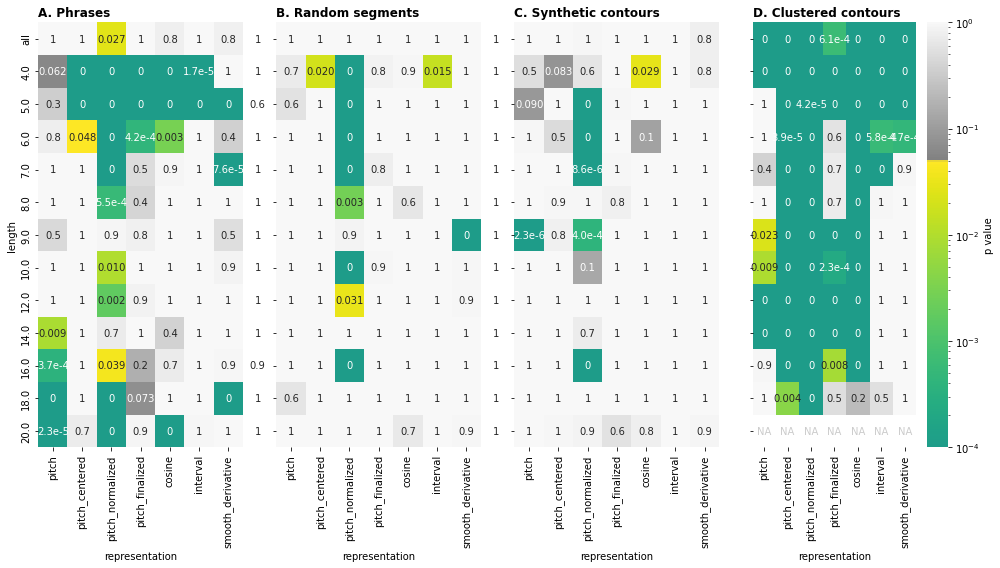

In [15]:
dfs = results_dip_test_representation_vs_length(
    'unique=="all" and dimensionality==50 and metric=="umap"',
    datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
    titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours'],
    values='diptest_p'
)
# plt.suptitle('Dist-dip test results by length (UMAP metric)', fontsize=14);
plt.savefig('../figures/fig-dist-dip-test-tables/per-length-umap.pdf')

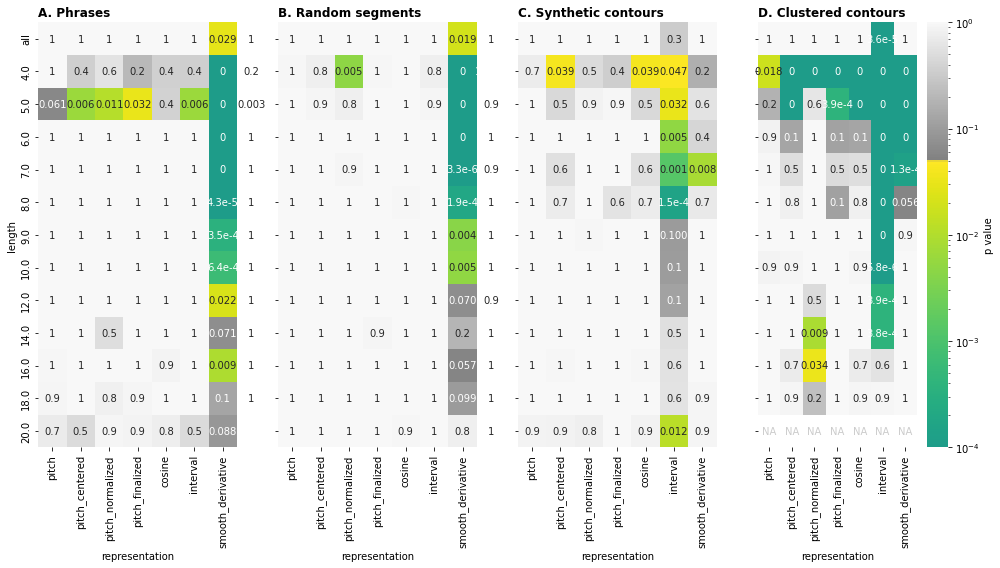

In [16]:
dfs = results_dip_test_representation_vs_length(
    'unique=="all" and dimensionality==50 and metric=="eucl"',
    datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
    titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours'],
    values='diptest_p'
)
# plt.suptitle('Dist-dip test results by length (Euclidean metric)', fontsize=14);
plt.savefig('../figures/fig-dist-dip-test-tables/per-length-eucl.pdf')

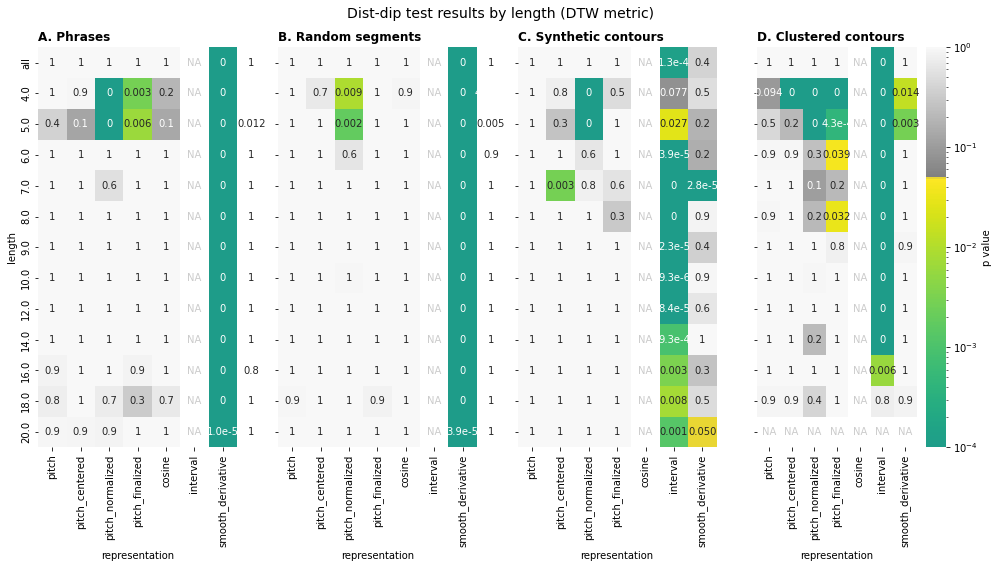

In [17]:
dfs = results_dip_test_representation_vs_length(
    'unique=="all" and dimensionality==50 and metric=="dtw"',
    datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
    titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours'],
    values='diptest_p'
)
plt.suptitle('Dist-dip test results by length (DTW metric)', fontsize=14);

In [18]:
# dfs = results_dip_test_representation_vs_length(
#     'unique=="all" and dimensionality==50 and metric=="corr"',
#     datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
#     titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours'],
#     values='diptest_p'
# )
# plt.suptitle('Dist-dip test results by length (Correlation distance)', fontsize=14);

### Number of contours per length

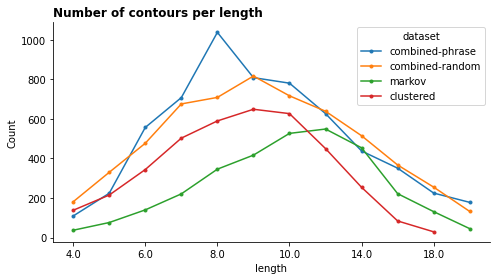

In [19]:
def show_num_contours(datasets, results=results, **kwargs):
    df = (results.query('unique=="all" and dimensionality==50 and metric=="umap"')
        .pivot_table(values='num_contours', index='length', columns='dataset')
        .reindex(columns=datasets, index=LENGTHS[1:]))
    fig, ax = plt.subplots(1, figsize=(7, 4), tight_layout=True)
    # sns.heatmap(df, annot=True, fmt='.0f')
    df.plot(marker='.', ax=ax)
    sns.despine()
    plt.ylabel('Count')
    title('Number of contours per length')

show_num_contours(datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'])
plt.savefig('../figures/fig-dist-dip-test-tables/length-distribution.pdf')

### Particular representations

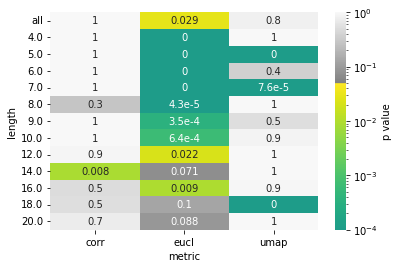

In [37]:
df = (results
    .query('dataset=="combined-phrase" and representation=="interval" and limit==3000 and dimensionality==50 and unique=="all"')
    .pivot(index='length', columns='metric', values='diptest_p')
    .reindex(index=LENGTHS)
)
show_p_values(df)

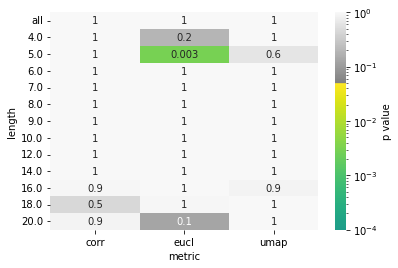

In [34]:
df = (results
    .query('dataset=="combined-phrase" and representation=="smooth_derivative" and limit==3000 and dimensionality==50 and unique=="all"')
    .pivot(index='length', columns='metric', values='diptest_p')
    .reindex(index=LENGTHS)
)
show_p_values(df)

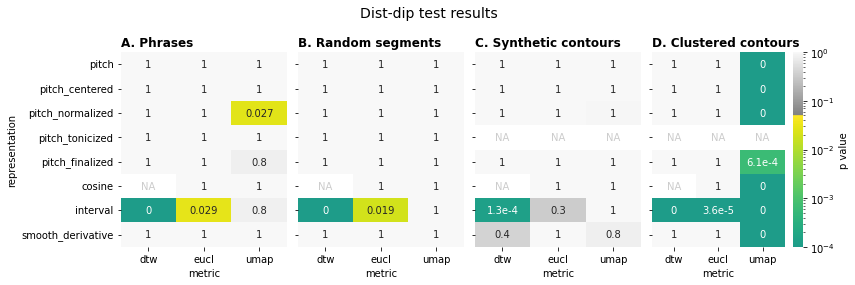

In [311]:
results_dip_test_representation_vs_metric(
    'unique=="all" and length=="all" and dimensionality==50',
    datasets=['combined-phrase', 'combined-random', 'markov', 'clustered'],
    titles=['A. Phrases', 'B. Random segments', 'C. Synthetic contours', 'D. Clustered contours'],
    values='diptest_p'
)
plt.suptitle('Dist-dip test results', fontsize=14);

In [312]:
def table2_df(results, query, values='tableone_p', index='representation', columns='length'):
    df = results.query(query).pivot_table(values=values, index=index, columns=columns)
    return df.reindex(index=ALL_REPRESENTATIONS)

def results_dip_test_representation_vs_metric(query, datasets, titles=None, results=results):
    N = len(datasets)
    fig, axs = plt.subplots(1, N, sharex=True, sharey=True, figsize=(N*3, 4), tight_layout=True)
    for i, (ax, dataset) in enumerate(zip(axs, datasets)):
        df = query_pivot(results, f'{query} and dataset=="{dataset}"')
        show_p_values(df, ax=ax, cbar=i == N-1)
        title(titles[i] if titles else dataset, ax=ax)
        if i >= 1:
            ax.set_ylabel('')

## Histograms

<AxesSubplot:xlabel='Umap distance'>

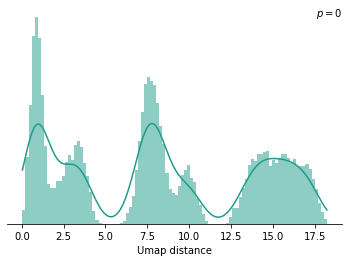

In [26]:
def show_distance_distribution(self,
        alpha=0.05, ax=None,
        annot=True,
        clean=True,
        uni_fmt='$p={}$', 
        multi_fmt='$p={}$', 
        text_kws={},
        hist_kws={},
    ):
    if ax is None: ax = plt.gca()
    _text_kws = dict(xy=(1, 1), xycoords='axes fraction', ha='right', va='top')
    _text_kws.update(text_kws)

    pval = self.dist_dip_test()['p']
    cmap = get_pval_cmap(min_gray=0.2, vmin=1e-5)
    norm = LogNorm(vmin=1e-5, vmax=1)
    _hist_kws = dict(lw=0, color=cmap(norm(pval + 1e-8)), stat='density', ax=ax)
    _hist_kws.update(hist_kws)
    sns.histplot(self.similarities_sample(), **_hist_kws)
    
    if annot:
        fmt = multi_fmt if pval < alpha else uni_fmt
        result = fmt.format(format_pval(pval))
        ax.annotate(result, **_text_kws)

    ax.set_xlabel(f'{self.metric.title()} distance')
    if clean:
        ax.set_ylabel('')
        ax.set_yticks([])
        sns.despine(left=True, ax=ax)
    return ax

condition = Condition('clustered', 'pitch_centered', 'umap', limit=3000, dimensionality=50)
ax = show_distance_distribution(condition, hist_kws=dict(kde=True, bins=100))
ax

In [2]:
condition = Condition('clustered', 'pitch_centered', 'umap', limit=3000, dimensionality=50)
condition.show_distance_distribution()

NameError: name 'LinearSegmentedColormap' is not defined